In [ ]:
# Gerekli kütüphaneleri yükleyin
import os
import shutil
import glob
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import tensorflow as tf
from tensorflow import keras

# Uyarıları gizle
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Keras ve TensorFlow modülleri
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNet, InceptionV3
from keras.applications.inception_v3 import preprocess_input

# Diğer kullanışlı kütüphaneler
import matplotlib.pyplot as plt


In [ ]:
# Eğitim ve Doğrulama Görüntüleri için Yollar
train_path ='C:/Users/esraa/Desktop/base_dir/train_dir'
valid_path ='C:/Users/esraa/Desktop/base_dir/val_dir'

In [ ]:
#dosya listelenmesi
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [ ]:
#Görüntü İşleme Fonksiyonu
def image_to_feature_vector(image, size=(224, 224)):
    return cv2.resize(image, size).flatten()

In [ ]:
# ### GPU'nun uygunluğunu kontrol etme
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [ ]:
def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

In [ ]:
# Girdi görüntüsünün yükseklik, genişlik ve renk ayarı.
IMG_CHANNELS = 3
IMG_ROWS = 224
IMG_COLS = 224
input_shape = (IMG_ROWS, IMG_COLS ,3)

train_samples_num = get_files(train_path)
val_samples_num   = get_files(valid_path)
#test_samples_num =  len(glob.glob(test_path+"/*"))

# Birkaç yararlı değeri bildirme
epochs = 30
num_train_samples = train_samples_num
num_val_samples = val_samples_num
train_batch_size = 32
val_batch_size = 32
image_size = 224

In [ ]:

# Bir ön-eğitimli imagenet modeli oluşturma
#mobile = keras.applications.mobilenet.MobileNet()

mobile = InceptionV3(input_shape=input_shape,weights='imagenet',include_top=False) 
# mobile = keras.applications.mobilenet.MobileNet(input_shape=input_shape,
#                                                 weights='imagenet',
#                                                 include_top=False) 

mobile.trainable = False
# imports the model and discards the last layer.
# Modeli düzenleme
x = mobile.output
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
x = GlobalAveragePooling2D()(x)
# Tahminler için dropout ve dense layer ekleme
x = Dropout(0.4)(x)
#layer to convert the features to a single element vector per image.
# let's add a fully-connected layer
x = Dense(1024,activation='relu')(x) 

#we add dense layers so that the model can learn more complex 
#functions and classify for better results.
x = Dense(512,activation='relu')(x) #dense layer 2
x = Dense(512,activation='relu')(x) #dense layer 3
# and a logistic layer -- let's say we have 7 classes
predictions = Dense(7, activation='softmax')(x)
#final layer with softmax activation for 7 classes

# Yeni çıktılı bir model oluşturma
model = Model(inputs=mobile.input, outputs=predictions)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 24,692,007 (94.19 MB)

 Trainable params: 2,889,223 (11.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

# Eğitilmeyen katmanların ağırlıklarını dondurma 
#for layer in model.layers[:-6]:
#   layer.trainable = False
#for layer in model.layers[159:]:
#   layer.trainable = True
   
# Modeldeki yeni katmanların özetine bakma
model.summary()

In [ ]:
# Creating training and validation set
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Üreticileri ayarlama
train_batches = data_gen.flow_from_directory(train_path,
                                             target_size=(image_size,image_size),
                                             batch_size=train_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

valid_batches = data_gen.flow_from_directory(valid_path,
                                             target_size=(image_size,image_size),
                                             batch_size=val_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

test_batches = data_gen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,
                                            shuffle=False,
                                            color_mode='rgb',
                                            class_mode='categorical'
                                            )

Found 4962 images belonging to 7 classes.
Found 552 images belonging to 7 classes.
Found 552 images belonging to 7 classes.


In [ ]:
# Modeli derleme (should be done *after* setting layers to non-trainable)
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

# Bir iterasyonda kaç adım gerektiğini bildirme
train_steps = train_batches.n // train_batches.batch_size
val_steps   = valid_batches.n // valid_batches.batch_size

# Modeli melanoma daha duyarlı hale getirmek için ağırlık ekleme
# class_weights={
#     0: 1.0,  # akiec
#     1: 1.0,  # bcc
#     2: 1.0,  # bkl
#     3: 1.0,  # df
#     4: 3.0,  # mel
#     5: 1.0,  # nv
#     6: 1.0,  # vasc
# }

# Save edilmiş model için dosya yolunu bildirme
filepath = "C:/Users/esraa/Desktop/base_dir/inception_model.keras""

# Modelin en iyi versiyonunu save etmek için bir checkpoint bildirme
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min')

# Öğrenme durgunlaştıkça öğrenme oranını azaltma
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=2,
                              verbose=1, 
                              mode='min', 
                              min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

In [ ]:
# Modeli eğitme
history = model.fit(
    train_batches,
    steps_per_epoch=train_steps,
    validation_data=valid_batches,
    validation_steps=val_steps,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7770 - loss: 1.3750
Epoch 1: loss improved from inf to 1.02556, saving model to G:/My Drive/SKIN-LESION-CLASSIFIER/inception_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 773s 5s/step - accuracy: 0.7771 - loss: 1.3728 - val_accuracy: 0.8051 - val_loss: 0.7478 - learning_rate: 1.0000e-04
Epoch 2/30
  1/155 ━━━━━━━━━━━━━━━━━━━━ 9:07 4s/step - accuracy: 0.9375 - loss: 0.3435
Epoch 2: loss improved from 1.02556 to 0.34347, saving model to G:/My Drive/SKIN-LESION-CLASSIFIER/inception_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9375 - loss: 0.3435 - val_accuracy: 0.5000 - val_loss: 1.4589 - learning_rate: 1.0000e-04
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8005 - loss: 0.7359
Epoch 3: loss did not improve from 0.34347
155/155 ━━━━━━━━━━━━━━━━━━━━ 803s 5s/step - accuracy: 0.8005 - loss: 0.7357 - val_accuracy: 0.8015 - val_loss: 0.6519 - learning_rate: 1.0000e-04
Epoch 4/30
  1/155 ━━━━━

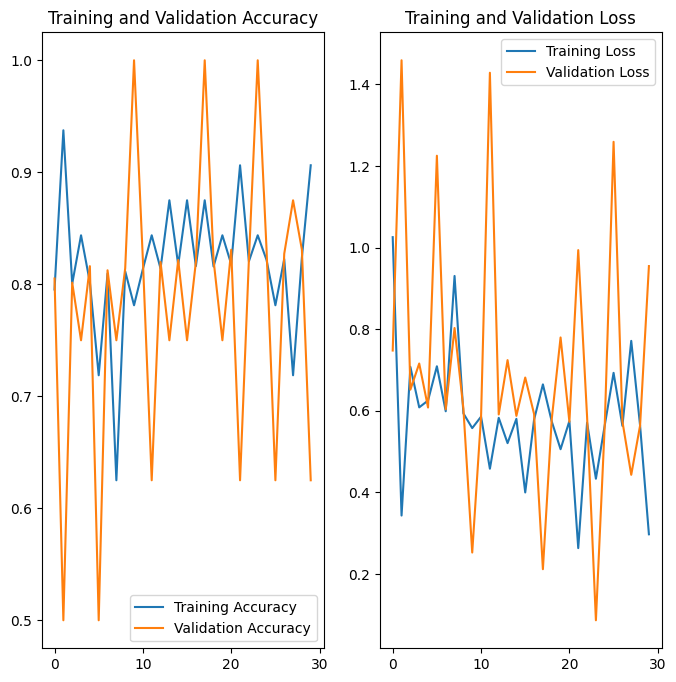

In [46]:
# Eğitim sonuçlarını görselleştirme
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Modelin tahminlerini al
test_labels = test_batches.classes
predictions = model.predict(test_batches, verbose=1)
predicted_classes = predictions.argmax(axis=1)

# Hassasiyet, geri çağırma, F1 skor hesaplama
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


In [ ]:
# Modeli hesaplama
#Son dönümün hesabı
val_loss, val_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_acc)

In [ ]:
# En iyi dönüm için hesaplama
model.load_weights(filepath)

val_loss, val_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_acc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step


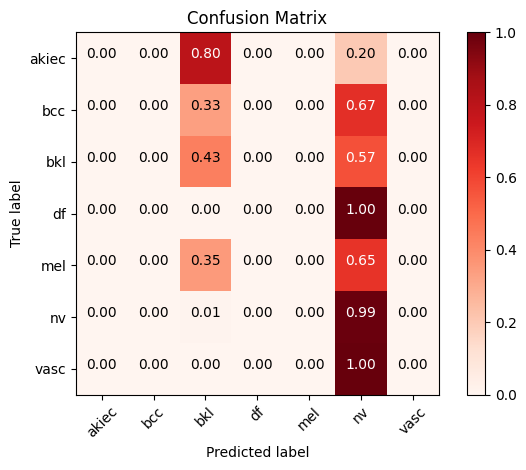

In [ ]:

# Test görüntülerinin confusion matrisini oluşturma
test_labels = test_batches.classes

# Tahmin yapma
predictions = model.predict(test_batches, test_batches.n // test_batches.batch_size + 1, verbose=1)
predictions = np.argmax(predictions, axis=1)

# Confusion matrisi fonksiyonu
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Reds):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(cm, cm_plot_labels)


image shape: (224, 224, 3)


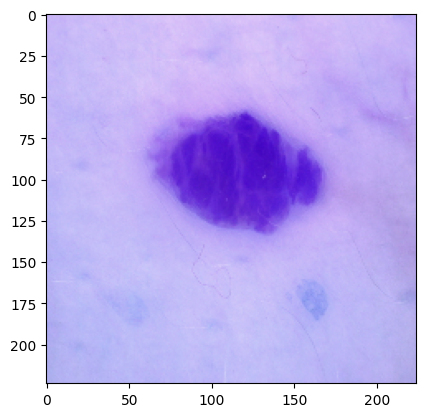

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.04748563 0.059079   0.16291285 0.02087086 0.09038831 0.58770853
  0.03155487]]
nv


In [ ]:

img_test = cv2.imread(valid_path+'/vasc/ISIC_0026876.jpg')
# Resizing image
img_scaled = cv2.resize(img_test,(image_size,image_size))
img_test = tf.image.convert_image_dtype(img_scaled, dtype=tf.float32,
                                        saturate=False)
print("image shape: {}".format(img_test.shape))
plt.imshow(img_test)
plt.show()
#img_test = img_test/255.

img_test = np.expand_dims(img_test, axis=0)
# getting model predictions
test_predictions = model.predict(img_test)
print(test_predictions)
predicted_label = np.argmax(test_predictions)

print(cm_plot_labels[predicted_label])

In [ ]:
# .keras modelini yükleme
model = tf.keras.models.load_model("C:/Users/esraa/Desktop/base_dir/inception_model.keras")

# Modeli .h5 formatında kaydetme
model.save("C:/Users/esraa/Desktop/base_dir/inception_model.h5")
